In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = l2_regularizer,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.6049382716049383, Loss: 1.0179104275173612
Checkpoint 20, Accuracy: 0.8148148148148148, Loss: 0.7775783538818359
Checkpoint 30, Accuracy: 0.8148148148148148, Loss: 0.7386392664026331
Checkpoint 40, Accuracy: 0.845679012345679, Loss: 0.6943752147533275
Checkpoint 50, Accuracy: 0.8333333333333334, Loss: 0.7948749683521412
Checkpoint 60, Accuracy: 0.845679012345679, Loss: 0.6372725875289352
Checkpoint 70, Accuracy: 0.8271604938271605, Loss: 0.5932997244375723
Checkpoint 80, Accuracy: 0.8888888888888888, Loss: 0.4284944534301758
Checkpoint 90, Accuracy: 0.8950617283950617, Loss: 0.4384032002201787
Checkpoint 100, Accuracy: 0.8950617283950617, Loss: 0.4059767899689851
Checkpoint 110, Accuracy: 0.8888888888888888, Loss: 0.4272232408876772
Checkpoint 120, Accuracy: 0.8888888888888888, Loss: 0.40719357243290655
Checkpoint 130, Accuracy: 0.8950617283950617, Loss: 0.41632715861002606
Checkpoint 140, Accuracy: 0.9012345679012346, Loss: 0.3995430557816117
Checkpoint 150,

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

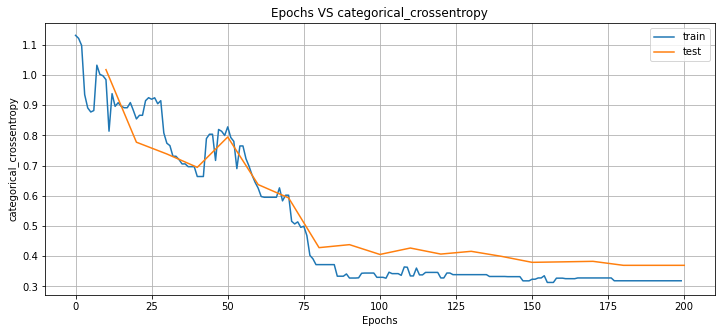

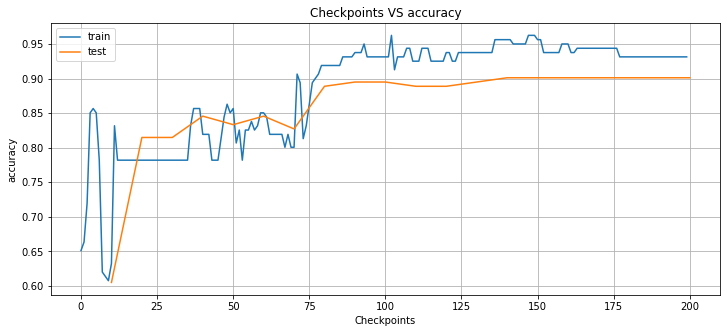

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.85602397 0.0341819  0.1097941 ]
[1. 0. 0.] <-> [0.8504388  0.0877566  0.06180465]
[0. 0. 1.] <-> [0.23657763 0.02053736 0.74288505]
[1. 0. 0.] <-> [0.7829947  0.11066434 0.10634094]
[1. 0. 0.] <-> [0.80454427 0.1047299  0.09072581]
[0. 0. 1.] <-> [0.70544887 0.03333552 0.2612157 ]
[1. 0. 0.] <-> [0.8550528  0.04492951 0.10001763]
[1. 0. 0.] <-> [0.8406112  0.07915333 0.08023551]
[1. 0. 0.] <-> [0.82183003 0.05824579 0.11992419]
[1. 0. 0.] <-> [0.84140193 0.07476368 0.0838344 ]
[1. 0. 0.] <-> [0.7911354  0.06478821 0.14407638]
[1. 0. 0.] <-> [0.80377984 0.06694265 0.12927753]
[1. 0. 0.] <-> [0.8388176  0.03602742 0.12515496]
[1. 0. 0.] <-> [0.8223963  0.07792605 0.09967759]
[1. 0. 0.] <-> [0.7448861  0.05176662 0.2033473 ]
[1. 0. 0.] <-> [0.82149994 0.10156101 0.07693902]
[0. 0. 1.] <-> [0.5624195  0.01439585 0.42318472]
[0. 1. 0.] <-> [0.6014454  0.35958934 0.03896523]
[0. 1. 0.] <-> [0.44404462 0.5090075  0.04694788]
[1. 0. 0.] <-> [0.87904257 0.02871536 0.09224205]


In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.6049382716049383, 'mean_square_error': 0.662447734484565, 'categorical_crossentropy': 1.0179104275173612, 'essential_metrics': {0: {'tp_hit': 36, 'fp_hit': 11, 'tn_hit': 19, 'fn_hit': 42}, 1: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 15}, 2: {'tp_hit': 7, 'fp_hit': 53, 'tn_hit': 41, 'fn_hit': 7}}, 'checkpoint': 10} 


{'accuracy': 0.8148148148148148, 'mean_square_error': 0.44344221123645844, 'categorical_crossentropy': 0.7775783538818359, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 30, 'tn_hit': 0, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 14}}, 'checkpoint': 20} 


{'accuracy': 0.8148148148148148, 'mean_square_error': 0.4332543564872933, 'categorical_crossentropy': 0.7386392664026331, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 30, 'tn_hit': 0, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hi

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.616328   -1.0287898  -0.95885116 -0.1114381   0.01321062]
 bias: 0.5068472027778625

Neuron 1: weights:
[-0.40653977  0.67760956  0.10066959 -0.67837316 -0.7731639 ]
 bias: 0.699408233165741

Neuron 2: weights:
[ 0.2828698  -1.0469197  -0.29398745  0.1253729   0.12525997]
 bias: 0.039990175515413284

Neuron 3: weights:
[-0.0248729   0.43169883  0.927565    0.9140715   0.6994851 ]
 bias: -0.0774640366435051

$
Layer 2
Neuron 0: weights:
[ 1.0256436  1.2217135  0.3123231 -1.5050144]
 bias: 0.39760494232177734

Neuron 1: weights:
[-1.6256341  1.1413841 -1.1698763  0.7445333]
 bias: 0.04650438576936722

Neuron 2: weights:
[ 0.587018   -1.8287114   1.1142015   0.39164084]
 bias: -0.3403015732765198

$

